In [1]:
import pkg_resources as pkg

path = pkg.resource_filename(__name__, "../")

import os

os.chdir(path)

/tmp/ipykernel_3118124/4031198830.py:2: DeprecationWarning: Use of .. or absolute path in a resource path is not allowed and will raise exceptions in a future release.
  path = pkg.resource_filename(__name__, "../")


In [ ]:
import torch
from pytorch_lightning import LightningModule

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

import matplotlib.pyplot as plt

import numpy as np
import seaborn as sns
import pandas as pd

from physioex.data import SleepPhysionet, TimeDistributedModule
from physioex.train.networks import TinySleepNet, ContrTinySleepNet

In [3]:
def compute_projections(model, datamodule, contr=False):
    train_projections = []
    y_train_true = []
    y_train_pred = []

    for batch in datamodule.train_dataloader():
        inputs, y_true = batch

        y_train_true.append(y_true)

        if contr:
            projections, y_pred = model(inputs.to(model.device))
        else:
            projections, y_pred = model.encode(inputs.to(model.device))

        y_train_pred.append(y_pred.cpu().detach().numpy())
        train_projections.append(projections.cpu().detach().numpy())

        del projections, y_pred

    y_train_true = np.concatenate(y_train_true).reshape(-1)
    train_projections = np.concatenate(train_projections).reshape(
        y_train_true.shape[0], -1
    )
    y_train_pred = np.concatenate(y_train_pred).reshape(-1, 5)

    return train_projections, y_train_true, y_train_pred

In [4]:
dataset = SleepPhysionet(version="2018", use_cache=True)
dataset.split(fold=0)
sequence_length = 3
batch_size = 32
datamodule = TimeDistributedModule(
    dataset=dataset,
    sequence_lenght=sequence_length,
    batch_size=batch_size,
    transform=None,
    target_transform=None,
)

ccl_model_path = "models/CCL/tinysleepnet/seqlen=3/SleepPhysionet/2018/fold=0-epoch=15-step=77670-val_acc=0.79.ckpt"
scl_model_path = "models/SCL/tinysleepnet/seqlen=3/SleepPhysionet/2018/fold=0-epoch=18-step=93864-val_acc=0.79.ckpt"

2023-12-28 14:58:59.623 | INFO     | physioex.data.utils:read_cache:11 - Reading chache from temp/sleep_physionet_2018.pkl


## PCA components plot

### Extracting the latent space projections from the similarity model

In [6]:
model = ContrTinySleepNet.load_from_checkpoint(scl_model_path).eval()
contr_train_projections, contr_y_train_true, contr_y_train_pred = compute_projections(
    model, datamodule, contr=True
)

model = TinySleepNet.load_from_checkpoint(ccl_model_path).eval()
train_projection, y_train_true, y_train_pred = compute_projections(
    model, datamodule, contr=False
)

# filtering
contr_preds = np.argmax(contr_y_train_pred, axis=1)
# contr_true_indx = np.where(contr_y_train_true == contr_preds or contr_y_train_true != contr_preds)[0]

preds = np.argmax(y_train_pred, axis=1)
# true_indx = np.where(y_train_true == preds or y_train_true != preds)[0]

In [ ]:
true_indx = [True for i in range(len(y_train_true))]
contr_true_indx = [True for i in range(len(contr_y_train_true))]

### Plotting the first 2 PCA components

In [ ]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(train_projection[true_indx, :])
true_positive = y_train_true[true_indx]

df = pd.DataFrame(
    {
        "First Principal Component": principal_components[:, 0],
        "Second Principal Component": principal_components[:, 1],
        "Group": true_positive,
    }
)

pca = PCA(n_components=2)
contr_principal_components = pca.fit_transform(
    contr_train_projections[contr_true_indx, :]
)
contr_true_positive = contr_y_train_true[contr_true_indx]

contr_df = pd.DataFrame(
    {
        "First Principal Component": contr_principal_components[:, 0],
        "Second Principal Component": contr_principal_components[:, 1],
        "Group": contr_true_positive,
    }
)

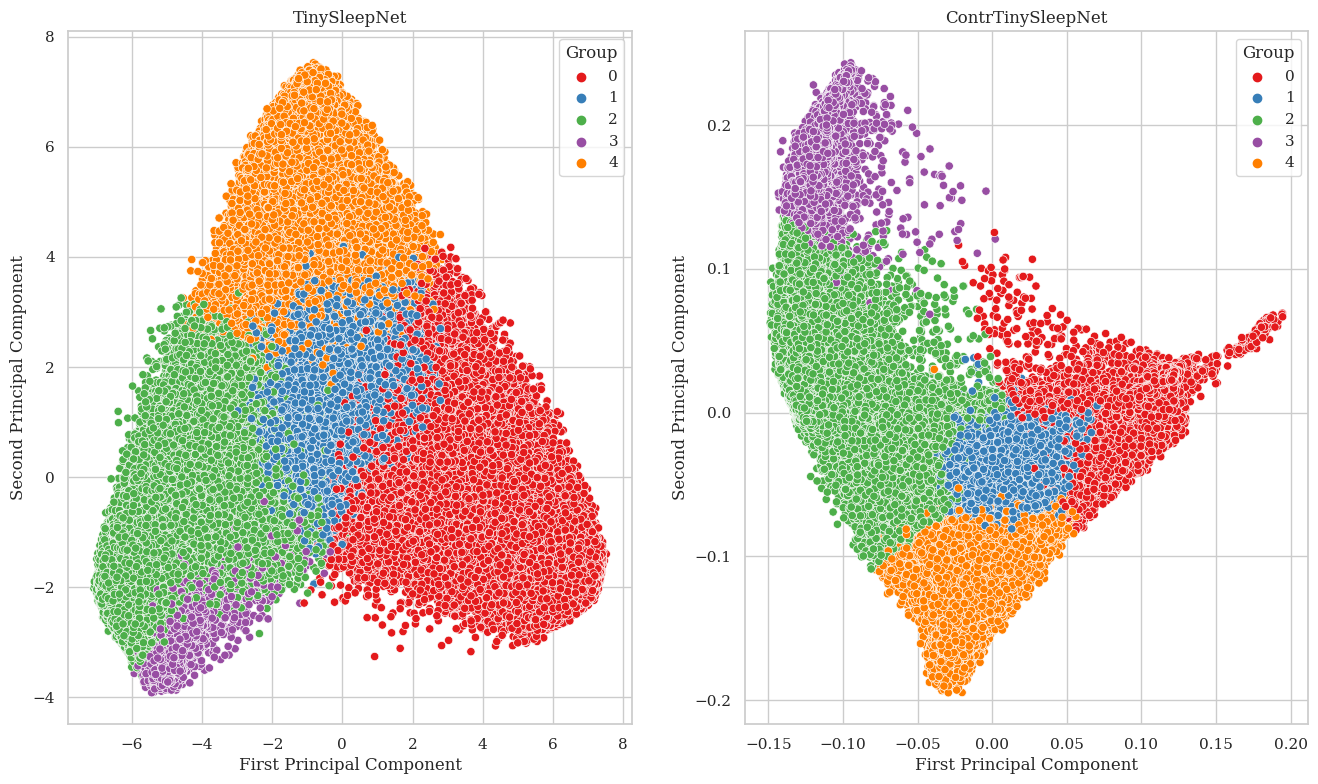

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 9))

# Utilizza seaborn.scatterplot
sns.scatterplot(
    data=df,
    x="First Principal Component",
    y="Second Principal Component",
    hue="Group",
    palette="Set1",
    ax=axes[0],
).set(title="TinySleepNet")
sns.scatterplot(
    data=contr_df,
    x="First Principal Component",
    y="Second Principal Component",
    hue="Group",
    palette="Set1",
    ax=axes[1],
).set(title="ContrTinySleepNet")

plt.show()
plt.close()

### Assessing the latent space quality measuring the ARI

In [ ]:
K_values = range(2, 10)

# Lista per memorizzare i risultati ARI
ari_values = []
contr_ari_values = []
for K in K_values:
    # Esegui K-Means con il valore corrente di K
    kmeans = KMeans(n_clusters=K, random_state=0).fit(train_projection[true_indx, :])
    # Calcola l'ARI confrontando le assegnazioni di K-Means con i true_positive
    ari = adjusted_rand_score(true_positive, kmeans.labels_)
    # Memorizza il risultato
    ari_values.append(ari)

    # Esegui K-Means con il valore corrente di K
    kmeans = KMeans(n_clusters=K, random_state=0).fit(
        contr_train_projections[contr_true_indx, :]
    )
    # Calcola l'ARI confrontando le assegnazioni di K-Means con i true_positive
    ari = adjusted_rand_score(contr_true_positive, kmeans.labels_)
    # Memorizza il risultato
    contr_ari_values.append(ari)

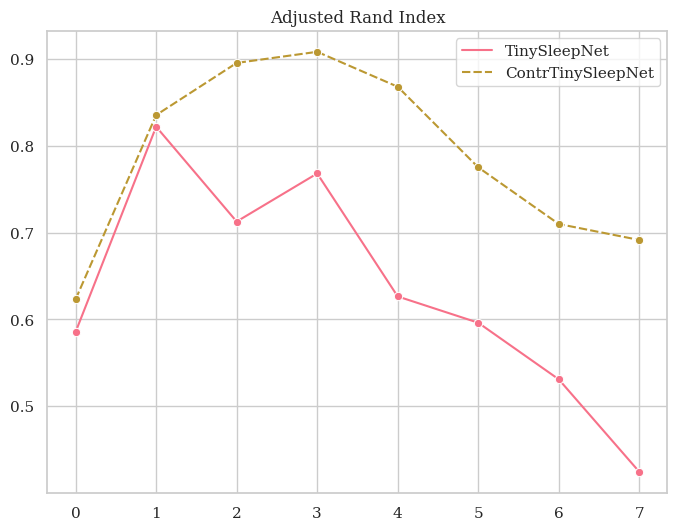

In [10]:
results = pd.DataFrame(
    {
        "Number of clusters (K)": K_values,
        "TinySleepNet": ari_values,
        "ContrTinySleepNet": contr_ari_values,
    }
)

# Plotta i risultati con Seaborn
plt.figure(figsize=(8, 6))
sns.lineplot(data=results[["TinySleepNet", "ContrTinySleepNet"]], marker="o").set(
    title="Adjusted Rand Index"
)
plt.show()
plt.close()

In [ ]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(train_projection[true_indx, :])
contr_kmeans = KMeans(n_clusters=5, random_state=0).fit(
    contr_train_projections[contr_true_indx, :]
)

df["KMeans"] = kmeans.labels_
contr_df["KMeans"] = contr_kmeans.labels_

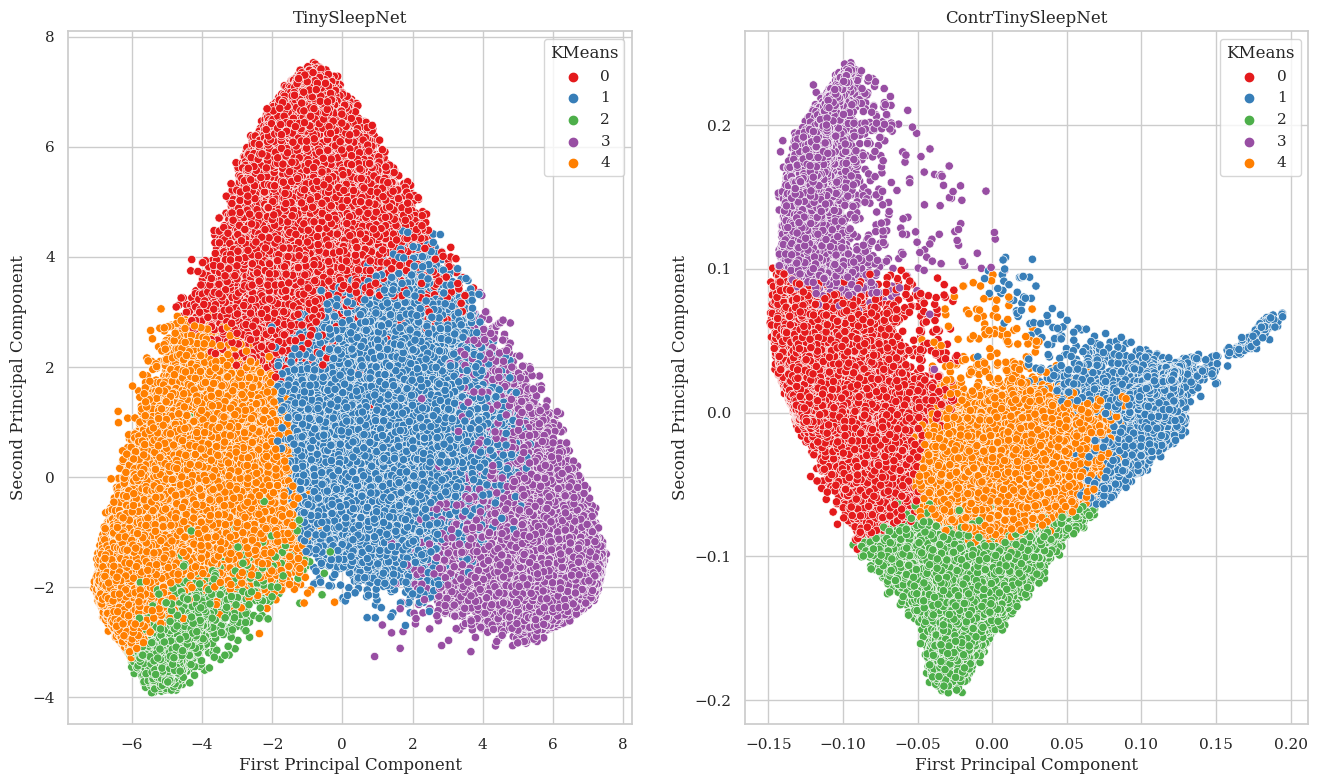

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(16, 9))

# Utilizza seaborn.scatterplot
sns.scatterplot(
    data=df,
    x="First Principal Component",
    y="Second Principal Component",
    hue="KMeans",
    palette="Set1",
    ax=axes[0],
).set(title="TinySleepNet")
sns.scatterplot(
    data=contr_df,
    x="First Principal Component",
    y="Second Principal Component",
    hue="KMeans",
    palette="Set1",
    ax=axes[1],
).set(title="ContrTinySleepNet")

plt.show()
plt.close()

In [1]:
import pkg_resources as pkg

path = pkg.resource_filename(__name__, "../")

import os

os.chdir(path)

/tmp/ipykernel_3070569/4031198830.py:2: DeprecationWarning: Use of .. or absolute path in a resource path is not allowed and will raise exceptions in a future release.
  path = pkg.resource_filename(__name__, "../")


In [4]:
from physioex.explain.ari_explainer import ARIExplainer

expl = ARIExplainer(
    model_name="tinysleepnet",
    dataset_name="sleep_physionet",
    ckp_path="models/CCL/tinysleepnet/seqlen=3/SleepPhysionet/2018/",
    version="2018",
    use_cache=True,
    sequence_lenght=3,
    batch_size=32,
    n_jobs=10,
)

2023-12-28 13:17:13.924 | INFO     | physioex.explain.ari_explainer:__init__:80 - Scanning checkpoint directory...
2023-12-28 13:17:13.928 | INFO     | physioex.explain.ari_explainer:__init__:91 - Found 10 checkpoints
2023-12-28 13:17:13.928 | INFO     | physioex.explain.ari_explainer:__init__:93 - {4: 'models/CCL/tinysleepnet/seqlen=3/SleepPhysionet/2018/fold=4-epoch=12-step=59964-val_acc=0.79.ckpt', 7: 'models/CCL/tinysleepnet/seqlen=3/SleepPhysionet/2018/fold=7-epoch=16-step=78492-val_acc=0.83.ckpt', 3: 'models/CCL/tinysleepnet/seqlen=3/SleepPhysionet/2018/fold=3-epoch=9-step=47304-val_acc=0.82.ckpt', 0: 'models/CCL/tinysleepnet/seqlen=3/SleepPhysionet/2018/fold=0-epoch=15-step=77670-val_acc=0.79.ckpt', 9: 'models/CCL/tinysleepnet/seqlen=3/SleepPhysionet/2018/fold=9-epoch=16-step=83264-val_acc=0.83.ckpt', 1: 'models/CCL/tinysleepnet/seqlen=3/SleepPhysionet/2018/fold=1-epoch=14-step=71040-val_acc=0.81.ckpt', 6: 'models/CCL/tinysleepnet/seqlen=3/SleepPhysionet/2018/fold=6-epoch=12-ste

In [5]:
expl.explain(plot_pca=True, plot_kmeans=True, n_jobs=1)

2023-12-28 13:17:30.087 | INFO     | physioex.explain.ari_explainer:compute_ari:101 - JOB:4-Loading model <class 'physioex.train.networks.tinysleepnet.TinySleepNet'> from checkpoint models/CCL/tinysleepnet/seqlen=3/SleepPhysionet/2018/fold=4-epoch=12-step=59964-val_acc=0.79.ckpt


2023-12-28 13:17:32.595 | INFO     | physioex.explain.ari_explainer:compute_ari:106 - JOB:4-Splitting dataset into train, validation and test sets
2023-12-28 13:19:59.297 | INFO     | physioex.explain.ari_explainer:compute_ari:123 - JOB:4-Computing PCA
2023-12-28 13:20:01.975 | INFO     | physioex.explain.ari_explainer:compute_ari:127 - JOB:4-Plotting PCA
2023-12-28 13:20:28.550 | INFO     | physioex.explain.ari_explainer:compute_ari:138 - JOB:4-Computing KMeans
/home/guido/miniconda3/envs/physioex/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
2023-12-28 13:22:48.678 | INFO     | physioex.explain.ari_explainer:compute_ari:141 - JOB:4-Computing PCA
2023-12-28 13:22:51.032 | INFO     | physioex.explain.ari_explainer:compute_ari:145 - JOB:4-Plotting PCA


KeyboardInterrupt: 